In [3]:
# Importation des librairies nécessaires
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Imported libraries")

Imported libraries


In [4]:
# Vérification de l'utilisation du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de {device} pour l'entraînement")

Utilisation de cuda pour l'entraînement


In [5]:
# Charger le dataset
input_csv = r"C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\dataset\text\text_lang_detector.csv"
df = pd.read_csv(input_csv, sep=";")
df.head()

,sentence,is_not_french
0,Y a -t -il un moyen d 'aller de Montreux -Vieu...,0
1,I would like to travel from culoz to buswiller...,1
2,He lied when he said he didn 't like her .,1
3,?N |ajOLIY6 ;DOM 'mKavLZZnkAi,0
4,a (c }sMyu7 /97 . [ -IA @m k0rN0U,0


In [6]:
# Prétraitement des données
def preprocess_data(df):
    X = df['sentence']
    y = df['is_not_french']
    return X, y

X, y = preprocess_data(df)

In [7]:
# Diviser les données
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(X, y)

In [8]:
# Tokenization et padding
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data):
    for text in data:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

max_len = 100

c:\Users\Seed\anaconda3\envs\travel_order\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Seed\anaconda3\envs\travel_order\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Seed\anaconda3\envs\travel_order\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT

In [9]:

def encode_text(text):
    tokens = tokenizer(text)
    token_ids = [vocab[token] for token in tokens]
    if len(token_ids) < max_len:
        token_ids += [vocab['<pad>']] * (max_len - len(token_ids))
    return token_ids[:max_len]

X_train_enc = [encode_text(text) for text in X_train]
X_test_enc = [encode_text(text) for text in X_test]

In [10]:
# Création d'une classe Dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_enc, y_train)
test_dataset = TextDataset(X_test_enc, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Définir le modèle
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<pad>'])
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=5)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Dynamically calculate the flattened size
        self.flattened_size = self._get_flattened_size(max_len)
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_flattened_size(self, seq_len):
        # Calculate output size after conv/pool layers
        seq_len = (seq_len - 5 + 1) // 2  # After conv1 and pool1
        seq_len = (seq_len - 5 + 1) // 2  # After conv2 and pool2
        return seq_len * 128  # Multiply by the number of filters in the last Conv layer

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [12]:
# Initialiser le modèle
embedding_dim = 50
model = CNNTextClassifier(vocab_size=len(vocab), embedding_dim=embedding_dim, num_classes=1).to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

c:\Users\Seed\anaconda3\envs\travel_order\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

        for X_batch, y_batch in progress_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=epoch_loss / len(train_loader))
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 0.0106


Epoch 2/10, Loss: 0.0028


Epoch 3/10, Loss: 0.0026


Epoch 4/10, Loss: 0.0028


Epoch 5/10, Loss: 0.0020


Epoch 6/10, Loss: 0.0022


Epoch 7/10, Loss: 0.0027


Epoch 8/10, Loss: 0.0063


Epoch 9/10, Loss: 0.0034


Epoch 10/10, Loss: 0.0045


### Classification Report ###
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    183170
         1.0       1.00      1.00      1.00     77179

    accuracy                           1.00    260349
   macro avg       1.00      1.00      1.00    260349
weighted avg       1.00      1.00      1.00    260349

### Accuracy ###
Accuracy: 0.9990


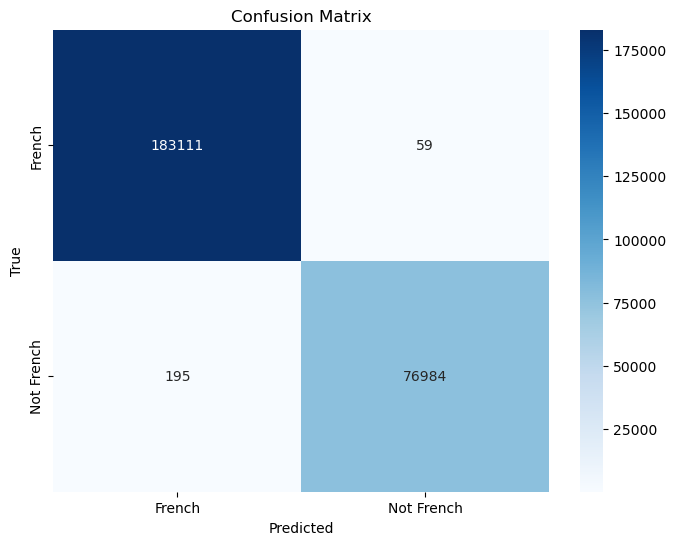

In [14]:
# Évaluation du modèle
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            predictions = (outputs > 0.5).float()
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    print("### Classification Report ###")
    print(classification_report(y_true, y_pred))
    print("### Accuracy ###")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["French", "Not French"], yticklabels=["French", "Not French"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(model, test_loader)

In [15]:
# Sauvegarder le modèle
model_path = r"C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\models\text_classification\cnn_lang_detector.pth"
torch.save(model.state_dict(), model_path)
print(f"Modèle sauvegardé dans : {model_path}")

# Prédictions sur de nouvelles phrases
new_sentences = [
    "I would like to go to the station.",
    "Voglio andare alla stazione.",
    "je veux partir de Marseille à Paris",
    "Ich möchte zum Bahnhof gehen.",
    "Quiero morir",
    "Je veux aller à la gare."
]

new_sentences_enc = [encode_text(text) for text in new_sentences]
new_sentences_tensor = torch.tensor(new_sentences_enc, dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    predictions = model(new_sentences_tensor).squeeze()
    predictions = (predictions > 0.5).float()

results = pd.DataFrame({
    'Sentence': new_sentences,
    'Predicted Language': ['French' if prediction == 0 else 'Not French' for prediction in predictions.cpu().numpy()]
})

import IPython
IPython.display.display(results)

Modèle sauvegardé dans : C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\models\text_classification\cnn_lang_detector.pth


,Sentence,Predicted Language
0,I would like to go to the station.,Not French
1,Voglio andare alla stazione.,Not French
2,je veux partir de Marseille à Paris,French
3,Ich möchte zum Bahnhof gehen.,Not French
4,Quiero morir,French
5,Je veux aller à la gare.,French
